In [1]:
!ls -l ~/data

total 1893632
-rwxr-xr-x 1 root root       3973 Jul  6 02:11 dataset-README.txt
-rw-r--r-- 1 root root     171308 Jul 13 03:52 movies.dat
-rw-r--r-- 1 root root   24594131 Jul 13 03:52 ratings.dat
-rw-r--r-- 1 root root       5577 Jul 13 03:52 README
-rw-r--r-- 1 root root     134368 Jul 13 03:52 users.dat
-rwxr-xr-x 1 root root   55583744 Jul  6 02:11 yoochoose-buys.dat
-rwxr-xr-x 1 root root 1486798186 Jul  6 02:13 yoochoose-clicks.dat
-rwxr-xr-x 1 root root  371725851 Jul  6 02:12 yoochoose-test.dat


In [4]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [37]:
original_data = data.copy()

## Step 1. 데이터의 전처리

### (1) 데이터 불러오기

UserID가 978300019 시간에 3186번 영화에 4점을 줬고, 잠시 후 978300055 시간에 1270 영화에 5점을 줬음을 알 수 있습니다. 노드에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터로 사용하기로 했습니다. 따라서 UserID 단위로 생성되어 있는 데이터를 Session 단위로 해석하기 위해서는 단순히 언제 UserID가 다른 값으로 바뀌는 지에 대해 생각해볼 수 있습니다.

978300019, 978300055와 같은 시간표현은 직관적이지도 않고 구분하기도 힘들기 때문에 다음과 같이 변형시켜주겠습니다.

In [64]:
from datetime import datetime
print(datetime.fromtimestamp(978300019).strftime("%Y-%m-%d %I:%M:%S"))
print(datetime.fromtimestamp(978300055).strftime("%Y-%m-%d %I:%M:%S"))

2000-12-31 10:00:19
2000-12-31 10:00:55


In [20]:
data['Time'] = data['Time'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d %I:%M:%S"))

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 10:00:19
22,1,1270,5,2000-12-31 10:00:55
27,1,1721,4,2000-12-31 10:00:55
37,1,1022,5,2000-12-31 10:00:55
24,1,2340,3,2000-12-31 10:01:43
36,1,1836,5,2000-12-31 10:02:52
3,1,3408,4,2000-12-31 10:04:35
7,1,2804,5,2000-12-31 10:11:59
47,1,1207,4,2000-12-31 10:11:59
0,1,1193,5,2000-12-31 10:12:40


가장 먼저 유저 수와 아이템 수를 각각 확인해보겠습니다.

In [25]:
print(f"총 유저 수: {data['UserId'].nunique()}")
print(f"총 아이템(영화) 수: {data['ItemId'].nunique()}")

총 유저 수: 6040
총 아이템(영화) 수: 3706


여기서의 유저 수가 총 세션 수라고는 할 수 없습니다. 데이터 자체의 길이가 여기서는 대략적인 세션 수처럼 생각을 할 수 있을텐데 데이터의 길이는 1000209 입니다.

### (2) 세션 길이

세션길이를 체크하면 전처리할 부분에 대해 생각해보겠습니다.

In [27]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [28]:
print(f"Median of session length: {session_length.median()}")
print(f"Mean of session length: {session_length.mean()}")
print(f"Minimum of session length: {session_length.min()}")
print(f"Maximum of session length: {session_length.max()}")
print(f"Quantile(0.999) of session length: {session_length.quantile(0.999)}")

Median of session length: 96.0
Mean of session length: 165.5975165562914
Minimum of session length: 20
Maximum of session length: 2314
Quantile(0.999) of session length: 1343.181000000005


간단하게 세션 길이에 대한 통계량들을 체크해봤습니다. 이를 이용해 체크하기 전에 데이터를 다시 한번 살펴보겠습니다. 데이터는 유저Id, 영화Id, 평점, 시간으로 구성되있습니다. 같은 UserId가 동일한 시간대에 선택한 영화는 실제 리뷰를 했다고 판단하기 어려울 것 같습니다. 이를 토대로 전처리를 해주고 다시 한번 통계량을 체크해보겠습니다.

먼저 UserId와 Time이 동일한 data들은 아래와 같습니다. 확인 후 `drop_duplicates`로 삭제를 하고 통계량을 다시 한번 체크해보겠습니다.

In [35]:
data[data.duplicated(subset=['UserId', 'Time'])]

,UserId,ItemId,Rating,Time
27,1,1721,4,2000-12-31 10:00:55
37,1,1022,5,2000-12-31 10:00:55
47,1,1207,4,2000-12-31 10:11:59
21,1,720,3,2000-12-31 10:12:40
44,1,260,4,2000-12-31 10:12:40
...,...,...,...,...
1000188,6040,535,4,2000-07-28 11:58:54
1000191,6040,3751,4,2000-07-28 11:59:42
1000162,6040,3362,4,2001-08-10 02:29:56
1000069,6040,1258,4,2001-08-10 02:31:49


In [39]:
data.drop_duplicates(subset=['UserId', 'Time'], inplace=True)

In [42]:
session_length = data.groupby('UserId').size()

print(f"Median of session length: {session_length.median()}")
print(f"Mean of session length: {session_length.mean()}")
print(f"Minimum of session length: {session_length.min()}")
print(f"Maximum of session length: {session_length.max()}")
print(f"Quantile(0.999) of session length: {session_length.quantile(0.999)}")

Median of session length: 43.0
Mean of session length: 78.00513245033113
Minimum of session length: 2
Maximum of session length: 893
Quantile(0.999) of session length: 670.4930000000031


전반적으로 모든 값들이 작아졌음을 확인할 수 있습니다. 이번에는 99.9%의 데이터는 670이하의 길이를 가지는데, 최대값은 893입니다. 최대 세션 길이를 가지는 데이터에 대해 확인해보겠습니다. 너무 짧은 간격으로 영화를 리뷰하거나 한 영화에 대해서 여러번 리뷰를 할 경우도 있을 수 있기 때문에 체크를 해보겠습니다.

In [45]:
long_session = session_length.loc[session_length==893].index[0]
long_session_user = data.loc[data['UserId'] == long_session]
long_session_user

,UserId,ItemId,Rating,Time
171477,1088,260,5,2000-11-22 10:09:11
171224,1088,912,5,2000-11-22 10:10:43
171113,1088,589,4,2000-11-22 10:14:04
172077,1088,1035,4,2000-11-22 10:16:59
171897,1088,3512,4,2000-11-22 10:19:37
...,...,...,...,...
171531,1088,2844,3,2003-02-18 12:58:13
171936,1088,2728,3,2003-02-18 12:59:03
171978,1088,3543,4,2003-02-18 01:02:22
171708,1088,2314,4,2003-02-23 10:22:03


In [46]:
long_session_user['ItemId'].nunique()

893

별 문제는 없는 데이터 같습니다. 단지 영화 리뷰를 많이 한 유저로 생각할 수 있을 것 같습니다. *(추가적으로 UserId 별로 ItemId가 모두 unique한지 체크해봐도 좋을 것 같습니다.)*

이번에도 노드에서처럼 세션길이의 누적값에 대해 시각화를 해보겠습니다.

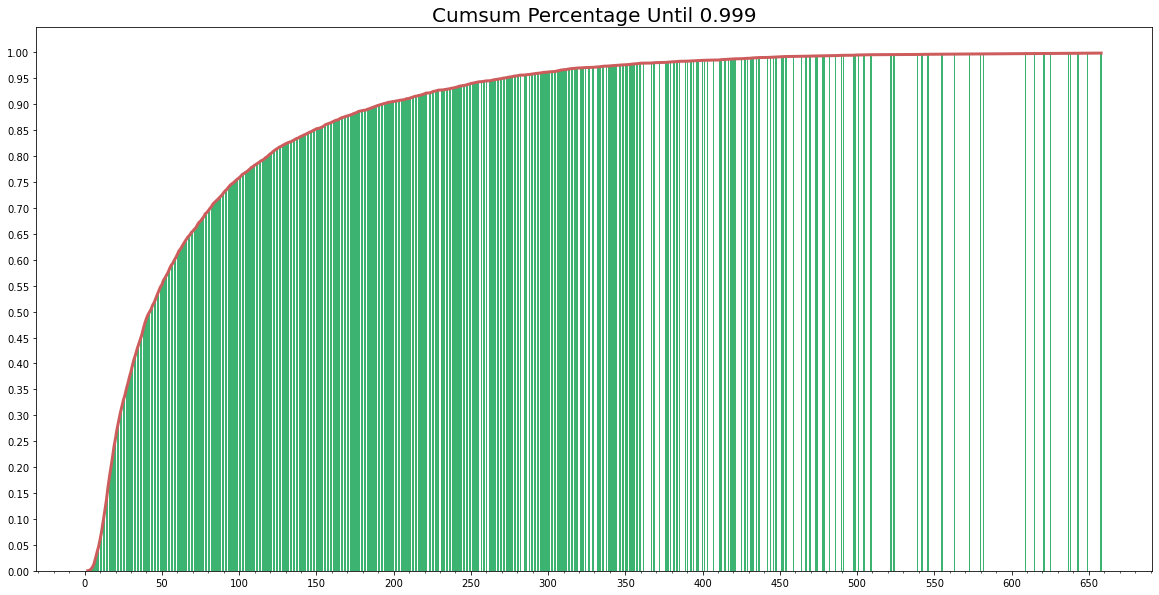

In [51]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999,
       color='mediumseagreen')

ax.plot(length_percent_cumsum_999.index, 
        length_percent_cumsum_999,
        color='indianred',
        lw=3)

ax.set_xticks(length_percent_cumsum_999.index)
ax.set_yticks(np.arange(0, 1.01, 0.05))

ax.set_title("Cumsum Percentage Until 0.999", size=20)



import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))


### (3) 세션 시간

In [52]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 11:05:32
2003-02-28 12:51:39


약 3년간의 데이터임을 위를 통해 확인할 수도 있습니다. 일단은 현재 사용하는 영화 데이터의 경우, 핸드폰이나 매일 사용하는 제품들과는 달리 트렌드에 그렇게 민감하지 않다고 판단할 수도 있을 것 같습니다. 따라서 일단은 3년간의 데이터 전부를 사용하는 방향으로 진행해보겠습니다. 

### (4) 데이터 정제
노드에서와 달리 세션길이의 최소값은 2로 나옵니다. 이렇게 되면 한 영화를 추천받았을 때 다른 영화를 추천받을 수 있으므로 노드의 과정과 같은 데이터 클렌징은 별도로 진행해주지 않았습니다. 하지만 우리의 목표는 영화를 골랐을 때 다음 영화를 추천하는 것이 목표이므로 rating이 어느정도 갖춰진 데이터만 필요하다고 생각할 수 있습니다. 따라서 rating이 3이상인 데이터만 사용하도록 정제를 해주겠습니다.

In [55]:
data = data.loc[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 10:00:19
22,1,1270,5,2000-12-31 10:00:55
24,1,2340,3,2000-12-31 10:01:43
36,1,1836,5,2000-12-31 10:02:52
3,1,3408,4,2000-12-31 10:04:35
...,...,...,...,...
999923,6040,232,5,2001-08-10 02:39:58
1000019,6040,2917,4,2001-08-10 02:40:29
999988,6040,1921,4,2001-08-10 02:41:04
1000167,6040,161,3,2001-08-10 02:41:26


In [56]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 11:05:32
2003-02-28 12:51:39


### (5) Train/ Valid/ Test split

데이터 셋을 시간에 따라 나눠주기 위해 우선 데이터 셋의 Time 컬럼을 datetime으로 바꿔줘야합니다.

In [74]:
data['Time'] = pd.to_datetime(data['Time'])
data.dtypes

UserId             int32
ItemId             int32
Rating             int32
Time      datetime64[ns]
dtype: object

현재는 트렌드에 민감하지 않다는 전제를 했기 때문에 데이터셋 자체를 8:1:1의 비율로 나눠주는 방법을 선택해보겠습니다.

In [111]:
sorted_data = data.sort_values(by=['UserId', 'Time'])
tr, val, test = sorted_data[:-int(len(sorted_data)*(0.2))], data[-int(len(sorted_data)*(0.2)):-int(len(sorted_data)*(0.1))], data[-int(len(sorted_data)*(0.1)):]

In [115]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [116]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 316188
	 Sessions: 4840
	 Items: 3507
	 First Time : 2000-07-06 01:32:19
	 Last Time : 2003-02-28 12:51:39

* valid Set Stats Info
	 Events: 39523
	 Sessions: 613
	 Items: 2808
	 First Time : 2000-06-02 01:11:41
	 Last Time : 2003-02-28 05:49:50

* test Set Stats Info
	 Events: 39523
	 Sessions: 588
	 Items: 2770
	 First Time : 2000-04-25 11:05:32
	 Last Time : 2003-02-28 01:12:12



In [117]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [118]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 316188
	 Sessions: 4840
	 Items: 3507
	 First Time : 2000-07-06 01:32:19
	 Last Time : 2003-02-28 12:51:39

* valid Set Stats Info
	 Events: 39523
	 Sessions: 613
	 Items: 2808
	 First Time : 2000-06-02 01:11:41
	 Last Time : 2003-02-28 05:49:50

* test Set Stats Info
	 Events: 39523
	 Sessions: 588
	 Items: 2770
	 First Time : 2000-04-25 11:05:32
	 Last Time : 2003-02-28 01:12:12



In [119]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

In [122]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [123]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 10:00:19,0
22,1,1270,5,2000-12-31 10:00:55,1
24,1,2340,3,2000-12-31 10:01:43,2
36,1,1836,5,2000-12-31 10:02:52,3
3,1,3408,4,2000-12-31 10:04:35,4
7,1,2804,5,2000-12-31 10:11:59,5
0,1,1193,5,2000-12-31 10:12:40,6
9,1,919,4,2000-12-31 10:22:48,7
51,1,608,4,2000-12-31 10:23:18,8
43,1,2692,4,2000-12-31 10:26:10,9


In [124]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4837, 4838, 4839])

In [125]:
tr_dataset.click_offsets

array([     0,     34,     94, ..., 316135, 316170, 316188], dtype=int32)

In [126]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [127]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 10:00:19,0
22,1,1270,5,2000-12-31 10:00:55,1
24,1,2340,3,2000-12-31 10:01:43,2
36,1,1836,5,2000-12-31 10:02:52,3
3,1,3408,4,2000-12-31 10:04:35,4
7,1,2804,5,2000-12-31 10:11:59,5
0,1,1193,5,2000-12-31 10:12:40,6
9,1,919,4,2000-12-31 10:22:48,7
51,1,608,4,2000-12-31 10:23:18,8
43,1,2692,4,2000-12-31 10:26:10,9


In [128]:
iter_ex = iter(tr_data_loader)

In [130]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 1 35 92 16]
Label Item Idx are :       [ 2 36 93 43]
Previous Masked Input Idx are []


## Step 3. 모델 구성

In [131]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [132]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [133]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [141]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [142]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3507)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      533850    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 3507)                178857    
Total params: 712,707
Trainable params: 712,707
Non-trainable params: 0
_________________________________________________________________


In [143]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### Train 1

In [144]:
train_model(model, args)

Train:   0%|          | 0/9729 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.68]

	 - Recall@20 epoch 1: 0.162135
	 - MRR@20    epoch 1: 0.041907



Train:   0%|          | 0/9729 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.53]

	 - Recall@20 epoch 2: 0.208610
	 - MRR@20    epoch 2: 0.055020



Evaluation:  93%|█████████▎| 1131/1215 [03:42<00:16,  5.09it/s]

	 - Recall@20 epoch 3: 0.224083
	 - MRR@20    epoch 3: 0.060159



In [145]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  95%|█████████▌| 1160/1216 [03:49<00:11,  5.07it/s]

	 - Recall@20: 0.225593
	 - MRR@20: 0.060122



0.22의 Recall@20 값을 확인할 수 있었습니다.

### Train 2

In [148]:
args = Args(tr, val, test, batch_size=32, hsz=64, drop_rate=0.1, lr=0.001, epochs=3, k=20)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 3507)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 64), (32, 64)]      686016    
_________________________________________________________________
dropout_2 (Dropout)          (32, 64)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 3507)                227955    
Total params: 913,971
Trainable params: 913,971
Non-trainable params: 0
_________________________________________________________________


In [149]:
train_model(model, args)

Train:   0%|          | 0/9729 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.73]

	 - Recall@20 epoch 1: 0.168684
	 - MRR@20    epoch 1: 0.043741



Train:   0%|          | 0/9729 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.1] 

	 - Recall@20 epoch 2: 0.214605
	 - MRR@20    epoch 2: 0.056303



Evaluation:  93%|█████████▎| 1131/1215 [03:35<00:15,  5.25it/s]

	 - Recall@20 epoch 3: 0.228365
	 - MRR@20    epoch 3: 0.060575



In [150]:
test_model(model, args, test)

Evaluation:  95%|█████████▌| 1160/1216 [03:41<00:10,  5.23it/s]

	 - Recall@20: 0.232651
	 - MRR@20: 0.062139



0.23의 Recall@20 값을 확인할 수 있었습니다.

### Train 3

In [151]:
args = Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.15, lr=0.001, epochs=3, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(16, 1, 3507)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 100), (16, 100)]    1082700   
_________________________________________________________________
dropout_3 (Dropout)          (16, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (16, 3507)                354207    
Total params: 1,436,907
Trainable params: 1,436,907
Non-trainable params: 0
_________________________________________________________________


In [152]:
train_model(model, args)

Train:   0%|          | 0/19459 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.74]

	 - Recall@20 epoch 1: 0.195369
	 - MRR@20    epoch 1: 0.051873



Train:   0%|          | 0/19459 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.83]

	 - Recall@20 epoch 2: 0.223490
	 - MRR@20    epoch 2: 0.059818



Evaluation:  97%|█████████▋| 2367/2431 [04:22<00:07,  9.01it/s]

	 - Recall@20 epoch 3: 0.229695
	 - MRR@20    epoch 3: 0.062519



In [153]:
test_model(model, args, test)

Evaluation:  98%|█████████▊| 2377/2433 [04:24<00:06,  8.99it/s]

	 - Recall@20: 0.231437
	 - MRR@20: 0.062377



0.23의 Recall@20 값을 확인할 수 있었습니다.

## 소감

우선 이런저런 약속에 백신을 핑계로 열심히 노드를 진행하지 못했습니다. Session based의 정확한 의미도 이해하지 못했고 노드를 최대한 기초에 두고 따라하는 것에 집중해서 진행하게 됐습니다.

따라서 추가적으로 해야할 공부를 우선적으로 정리해보겠습니다.

1. Session based 추천 시스템 확실하게 이해하기.
    * 시계열 데이터를 사용해 문제를 풀 때 처럼 어떻게 데이터를 나눠야 할 지에 대해 많이 헷갈렸기 때문에 추가적으로 공부를 해야겠다.
2. Session을 어떻게 나눌 것인지 생각하고 다시 진행해보기.
    * 이번 노드에서는 브라우저가 꺼지는 기준으로 세션을 나누는 것 보다 UserId로 데이터를 모으는 것이 더 중요하다고 생각해 Session을 별도로 나누지는 않았다.
3. 미니 배치 구성에 대해 이해하기.

추가적으로 이번주 내로 밀린 노드들을 다시 한번 보고 우수 노드들을 토대로 정리해야겠다고 생각하게 됐습니다.